### Thermal wind balance transport estimation -- using new 600m isoabth boundary between ASC and ACoC
Based on salinity and temperature difference, see Sohail et al. 2024

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import glob
import os

In [2]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [5]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [ ]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

In [43]:
import dask.config
from dask.distributed import Client,LocalCluster


c = Client()


In [44]:
c

<Client: 'tcp://127.0.0.1:44271' processes=7 threads=28, memory=125.19 GiB>

In [8]:
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yt_ocean = slice(-79,-60)).chunk({ 'yt_ocean':250, 'xt_ocean':1200})
ht

<xarray.DataArray 'ht' (yt_ocean: 440, xt_ocean: 3600)> Size: 6MB
dask.array<rechunk-merge, shape=(440, 3600), dtype=float32, chunksize=(250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [9]:
# location limits of dataset - choosing slice near totten
#lon_lim = slice(-270, -230) #slice(30, 45)#
lat_lim = slice(-79, -60) #slice(-70, -65)

ht_region = ht.sel( yt_ocean = lat_lim)

In [10]:
exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_wthmp


In [11]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
flex_period = slice(start_time_mw , end_time_mw)

In [12]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60)).chunk({ 'yu_ocean':250, 'xu_ocean':1200})

In [13]:
area_t = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xt_ocean= lon_lim, yt_ocean = lat_lim)


In [14]:
# Import edges of st_ocean and add lat/lon dimensions:  , start_time=start_time_mw, end_time=end_time_mw,
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': ht.yt_ocean, 'xt_ocean': ht.xt_ocean}, axis=[1, 2])


# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))


In [15]:
thickness

<xarray.DataArray 'st_edges_ocean' (st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 950MB
dask.array<sub, shape=(75, 440, 3600), dtype=float64, chunksize=(75, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [16]:
hu.load()

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [1931.0061, 1857.9861, 1785.2361, ..., 2235.639 , 2171.7917,
        2056.375 ],
       [1931.0061, 1857.9861, 1785.2361, ..., 2235.639 , 2171.7917,
        2062.0557],
       [1979.5555, 1882.7916, 1777.5416, ..., 2225.014 , 2179.8057,
        2082.9443]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yu_ocean, xu_ocean) float32 6MB nan nan nan ... -60.02 -60.02
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [17]:
st_edges_ocean

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 76)> Size: 608B
array([0.000000e+00, 1.082562e+00, 2.278908e+00, 3.600997e+00, 5.062046e+00,
       6.676655e+00, 8.460964e+00, 1.043281e+01, 1.261188e+01, 1.501997e+01,
       1.768113e+01, 2.062195e+01, 2.387179e+01, 2.746312e+01, 3.143179e+01,
       3.581741e+01, 4.066373e+01, 4.601908e+01, 5.193684e+01, 5.847596e+01,
       6.570151e+01, 7.368533e+01, 8.250670e+01, 9.225307e+01, 1.030209e+02,
       1.149166e+02, 1.280572e+02, 1.425717e+02, 1.586020e+02, 1.763040e+02,
       1.958489e+02, 2.174242e+02, 2.412350e+02, 2.675053e+02, 2.964787e+02,
       3.284196e+02, 3.636136e+02, 4.023675e+02, 4.450091e+02, 4.918859e+02,
       5.433625e+02, 5.998174e+02, 6.616377e+02, 7.292120e+02, 8.029216e+02,
       8.831294e+02, 9.701670e+02, 1.064320e+03, 1.165816e+03, 1.274803e+03,
       1.391349e+03, 1.515420e+03, 1.646887e+03, 1.785522e+03, 1.931006e+03,
       2.082944e+03, 2.240881e+03, 2.404321e+03, 2.572745e+03, 2.745633e+03,
       2.922475e+03, 3.102788e+03, 3.286119e+03, 3.472058e+03, 3.660233e+03,
       3.850315e+03, 4.042017e+03, 4.235086e+03, 4.429308e+03, 4.624497e+03,
       4.820497e+03, 5.017173e+03, 5.214414e+03, 5.412126e+03, 5.610229e+03,
       5.808657e+03])
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 608B 0.0 1.083 ... 5.809e+03
Attributes:
    long_name:       tcell zstar depth edges
    units:           meters
    cartesian_axis:  Z
    positive:        down
    ncfiles:         ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg...

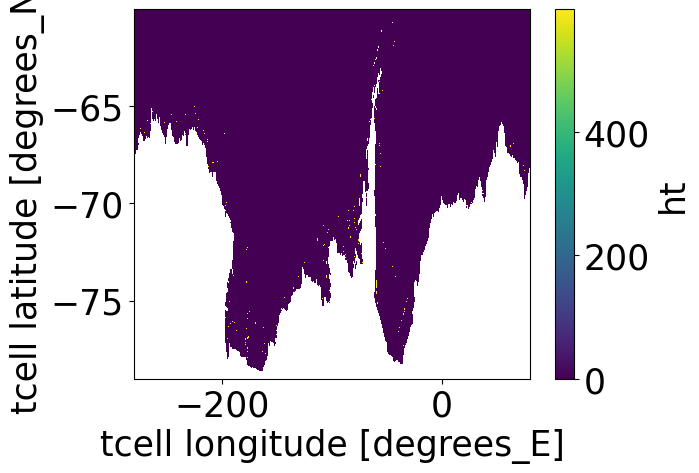

In [25]:
### now use mask that only take the edge of the boundary 
# sohail used delta S over the domain - N edge - S edge
st_600 = st_edges_ocean.sel(st_edges_ocean=600, method = 'nearest').load().values
st_2000 = st_edges_ocean.sel(st_edges_ocean=2000, method = 'nearest').load().values
st_100 = st_edges_ocean.sel(st_edges_ocean=100, method = 'nearest').load().values

mask_bound_ASC_CC = xr.where(ht==st_600, True, False) 
#mask_N_CC = xr.where((ht < 600) & (ht > 200), True, False) 
mask_S_CC = xr.where( ht==st_100 , True, False) 
mask_N_ASC = xr.where(ht ==st_2000, True, False) 
(mask_bound_ASC_CC*ht).plot()

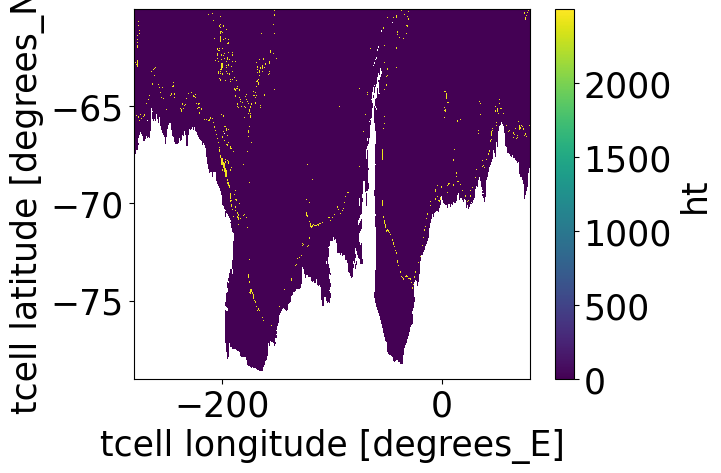

In [32]:
mask_500_1000 = xr.where((ht < 600) & (ht >500 ), True, False) 
mask_0_500 = xr.where( ht < 200 , True, False) 
mask_1500_2000 = xr.where((ht < 2500) & (ht > 2400), True, False) 
mask_1000_1500 = xr.where((ht < 700) & (ht > 600), True, False) 

(mask_1500_2000*ht).plot()
## this does not really look representative of the southern edge of the ASC,
## BUT this is also no different from computing circumpolar ave by isobath and selecting range!

In [18]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [19]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [20]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [21]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [22]:
vel = xr.merge([hu,coordinates, ht, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [23]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [24]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

In [25]:
## mask with clusters
cluster_mask_access = xr.open_mfdataset('/home/561/qo9901/Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
cluster_mask_access= cluster_mask_access.assign_coords(xu_ocean = ('xu_ocean', hu.xu_ocean.data), yu_ocean = ('yu_ocean', hu.yu_ocean.data))

### interpolate to t grid
cluster_mask_access = grid.interp(cluster_mask_access.__xarray_dataarray_variable__, axis = ['X','Y'])

In [26]:
cluster_mask_access

<xarray.DataArray '__xarray_dataarray_variable__' (yt_ocean: 440, xt_ocean: 3600)> Size: 2MB
dask.array<transpose, shape=(440, 3600), dtype=bool, chunksize=(440, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05

## Checking isobath range for ASC/ACOC boundaries

In [25]:
ualong_decademean_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_wthmp + '.nc')
ualong_decademean_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_wthp + '.nc')
ualong_decademean_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_decademean_' + exp_ctrl + '.nc')
ualong_decademean_wthmp

<xarray.Dataset> Size: 76MB
Dimensions:   (xu_ocean: 3600, yu_ocean: 440, decade: 5)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
  * decade    (decade) int64 40B 0 1 2 3 4
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
Data variables:
    u_along   (decade, yu_ocean, xu_ocean) float64 63MB dask.array<chunksize=(5, 440, 3600), meta=np.ndarray>
Attributes:
    units:        m/s
    description:  Time-mean along slope velocity for each decade of MW exprim...

In [26]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -80


In [27]:
levels_ualong = np.arange(-0.11,0.11,0.01)


In [28]:
def changeline_cs(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('k')
        #col.set_linewidth(2)


In [29]:
def changeline_cs_g(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('g')
        #col.set_linewidth(2)


In [30]:
def changeline_cs_r(linestyle):
    cs.monochrome = True
    for col,  ls in zip(cs.collections,cs._process_linestyles(linestyle)):
        col.set_linestyle(ls)
        col.set_edgecolor('r')
        #col.set_linewidth(2)


In [31]:
hu_region = hu.sel(yu_ocean = lat_lim)

Text(0.5, 0, '')

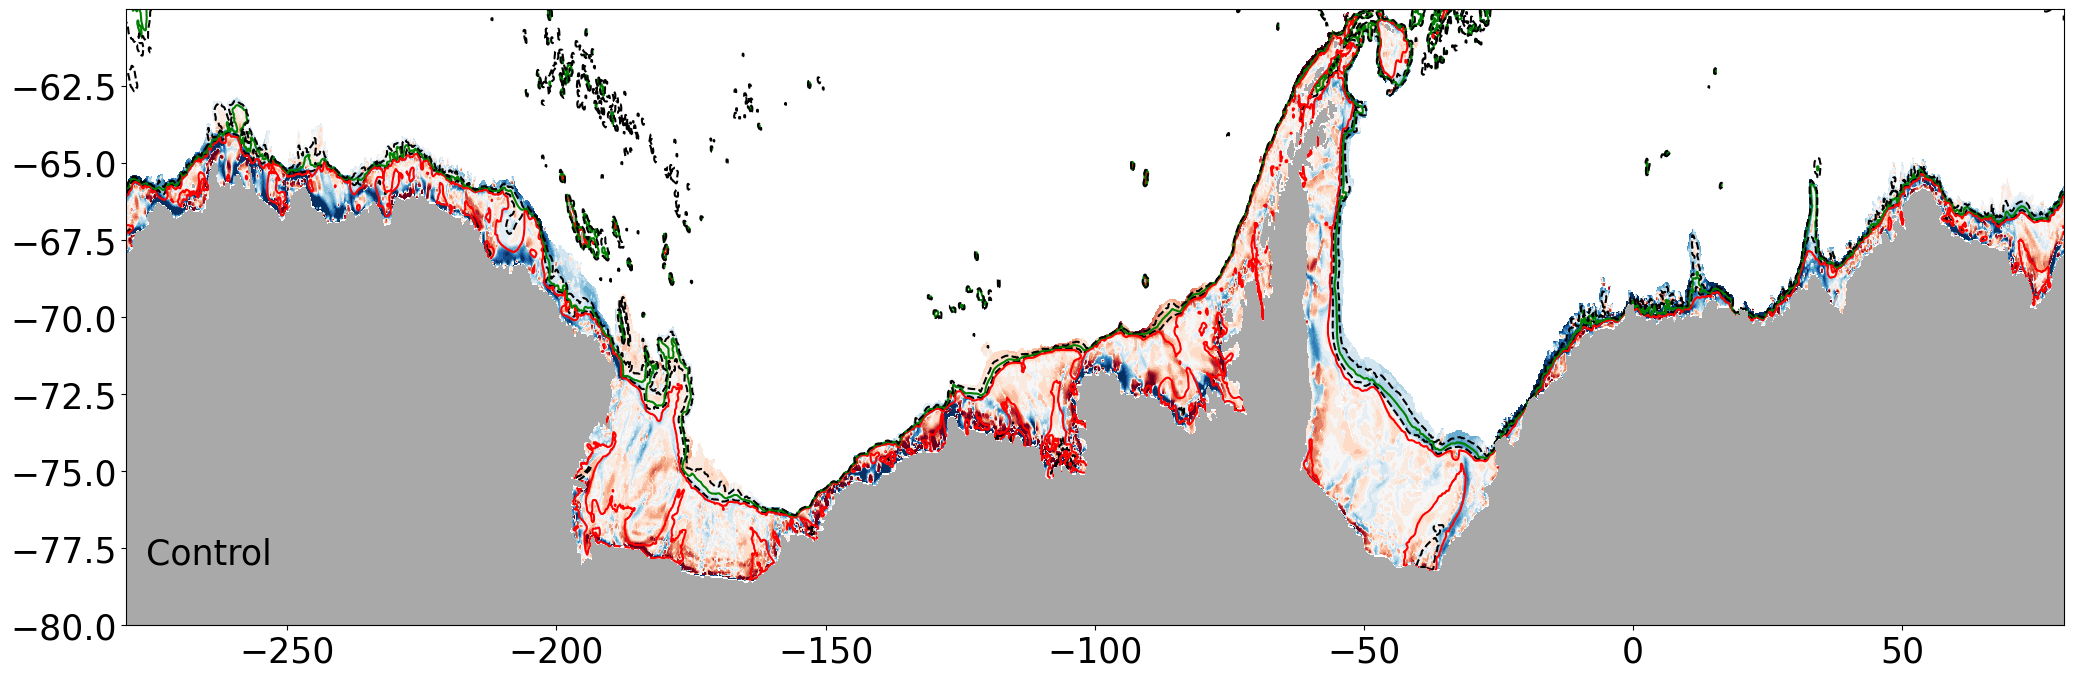

In [41]:
fig, ax = plt.subplots(figsize = (25,8))

# accessom2-01
cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax)
#cs = hu_region.where(hu_region < 2600).plot.contour(levels  = [2500], color = 'k', ax = ax[0])
#changeline_cs('solid')
cs = hu_region.plot.contour(levels  = [1000], color = 'k', ax = ax, linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')
cs = hu_region.plot.contour(levels  = [600], color = 'r', ax = ax) #conventional definition for ASC
changeline_cs_r('solid')

cs = hu_region.plot.contour(levels  = [1500], color = 'g', ax = ax) #conventional definition for ASC
changeline_cs_g('solid')
cs = hu_region.plot.contour(levels  = [2000], color = 'k', ax = ax, linestyle = 'dashed') #conventional definition for ASC
changeline_cs('dashed')

ax.set_ylabel('')
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax.text(0.01,0.1,'Control',transform=ax.transAxes)
ax.set_xlabel('')


In [33]:
mask_ASC_N = xr.where((hu<2000) & ( hu > 1500), True, False)
mask_ASC_S = xr.where((hu<1500) & ( hu > 1000), True, False)
mask_ACoC_N = xr.where((hu<1000) & ( hu > 700), True, False)
mask_ACoC_S = xr.where(hu<700, True, False)

In [34]:
import cmocean
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

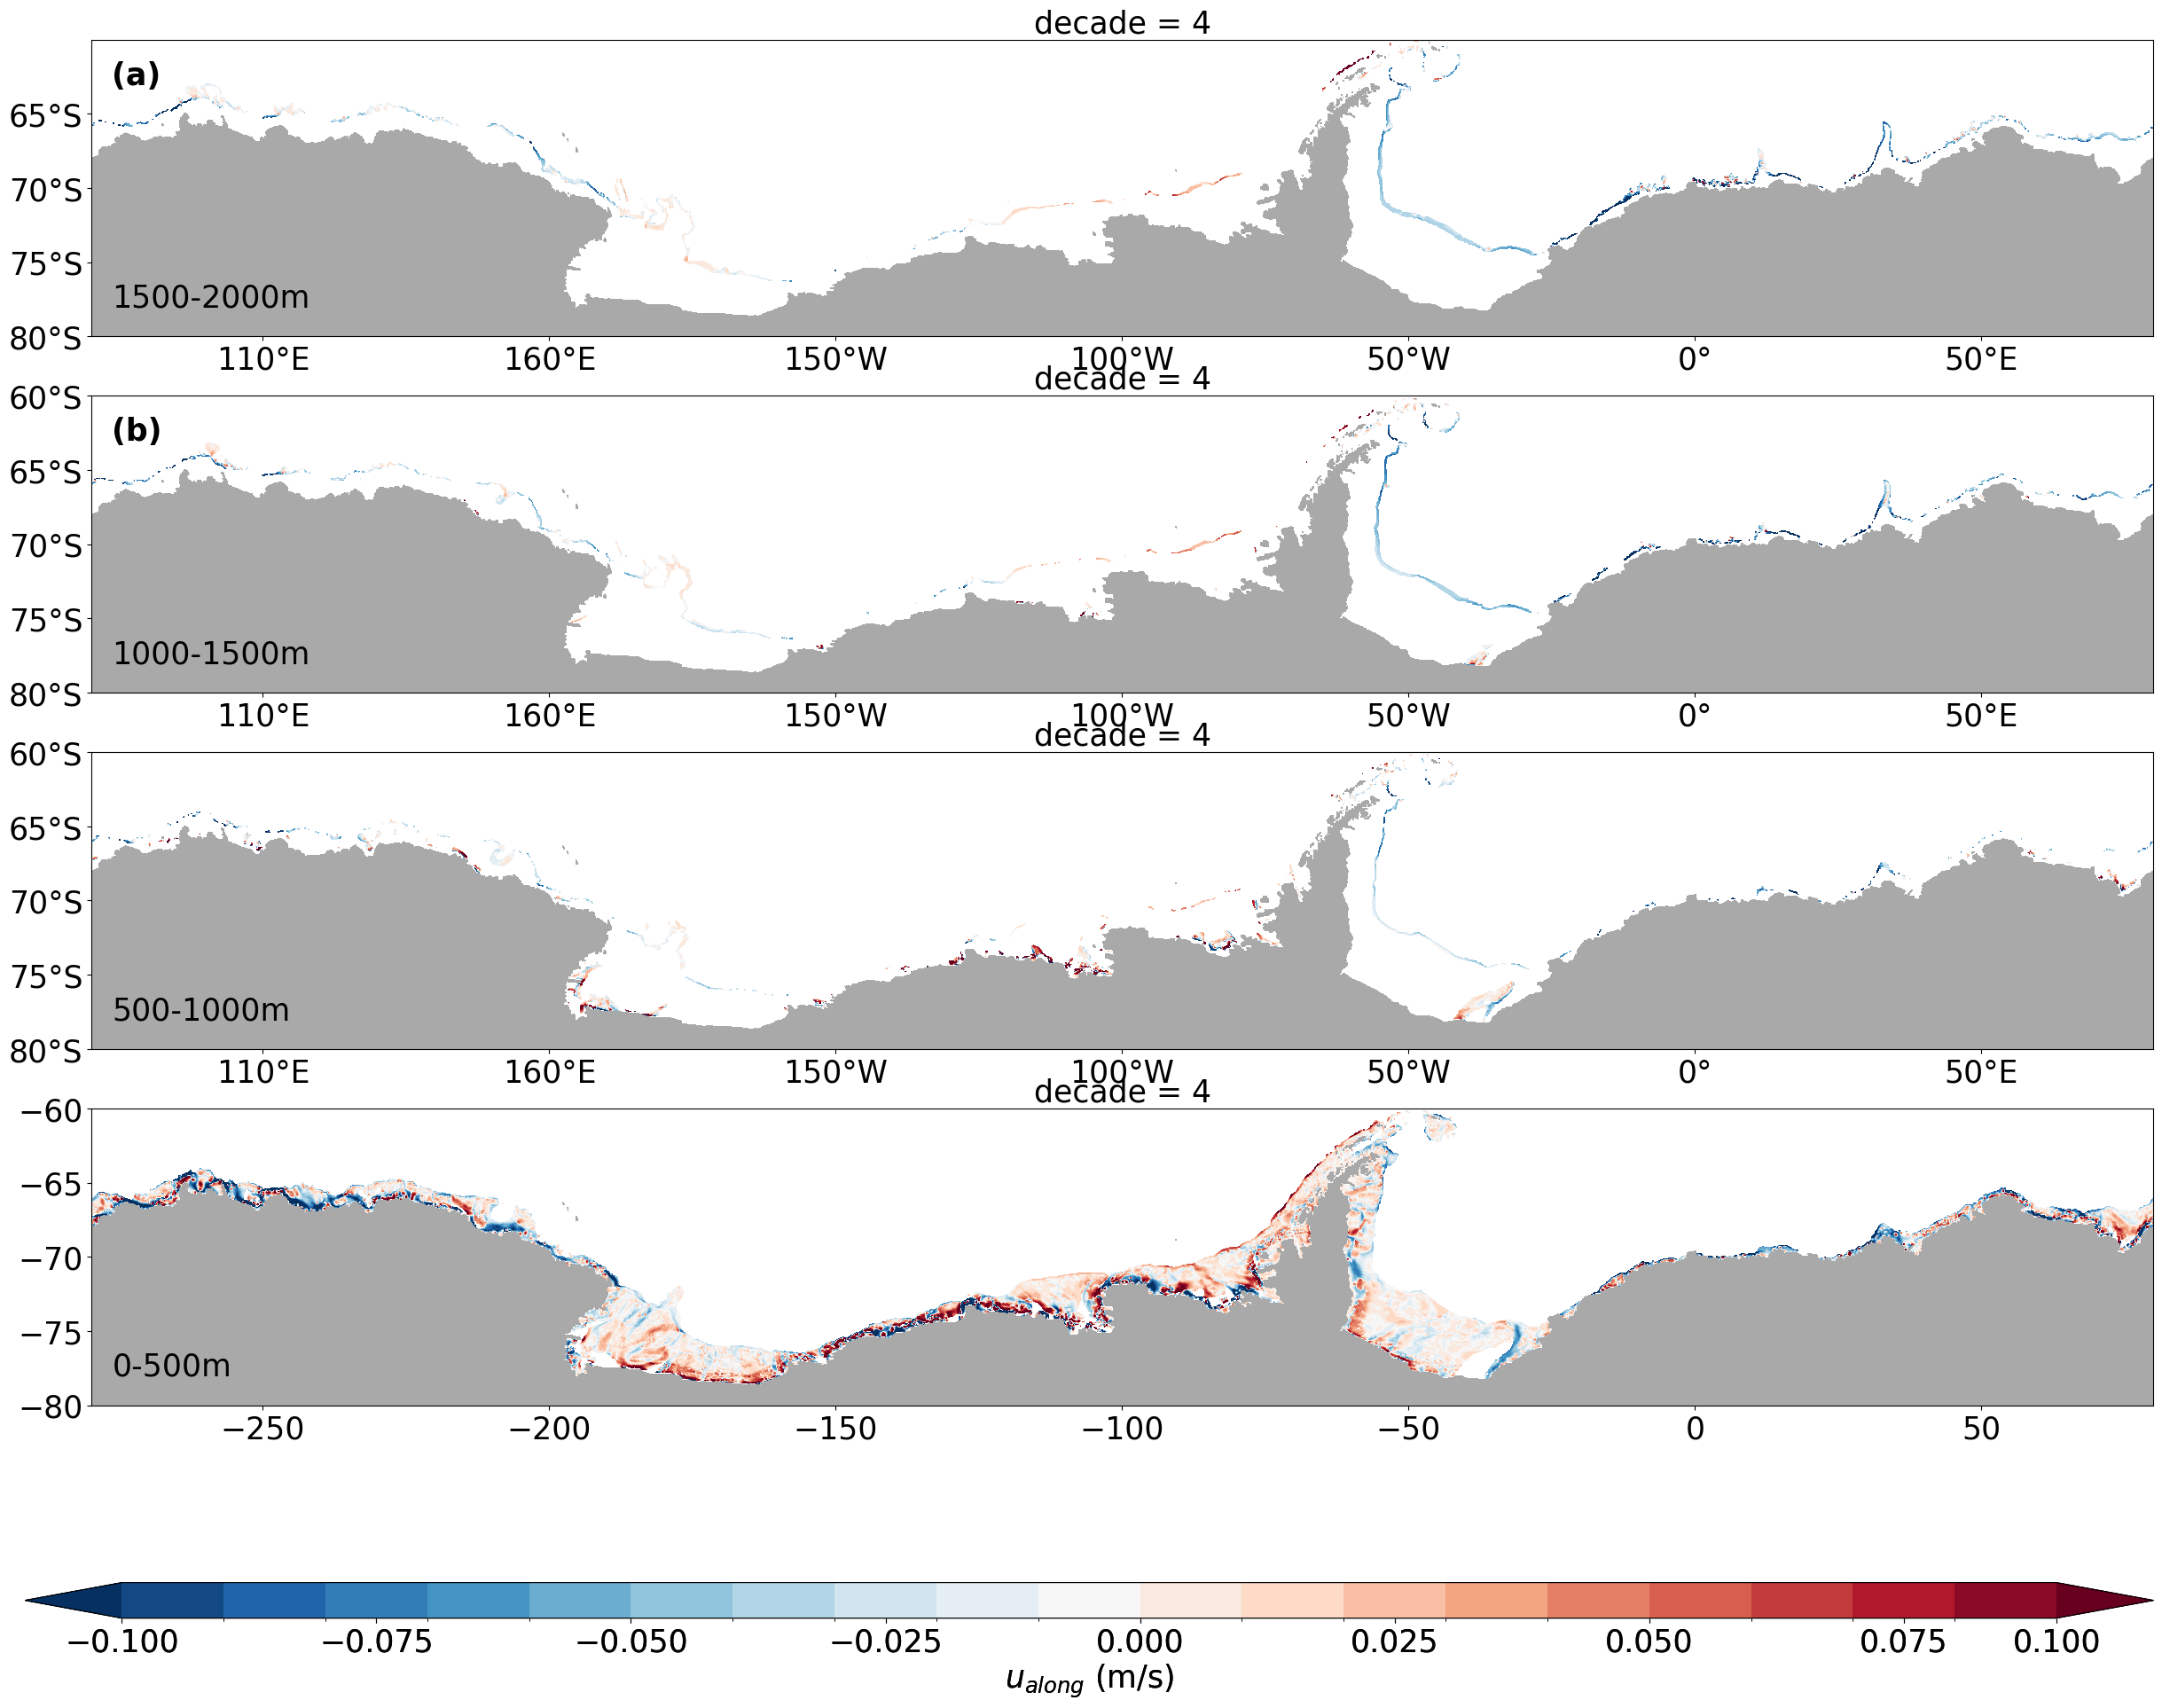

In [58]:
fig, ax = plt.subplots(nrows =4 ,figsize = (30,20))

# accessom2-01
cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ASC_N == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[0])

ax[0].set_ylabel('')
ax[0].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[1].text(0.01,0.1,'1500-2000m',transform=ax[0].transAxes)
ax[0].set_xlabel('')
ax[0].text(0.01,0.85,'(a)', transform=ax[0].transAxes, fontweight = 'bold')



cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ASC_S == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[1])

ax[1].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[1].set_ylim([-80,-60])
ax[1].text(0.01,0.1,'1000-1500m',transform=ax[1].transAxes)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].text(0.01,0.85,'(b)', transform=ax[1].transAxes, fontweight = 'bold')

cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax, pad = 0.1)
cbar.set_ticks(np.arange(-0.1,0.125,0.025))


cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ACoC_N == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[2])


ax[2].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[2].set_ylim([-80,-60])
ax[2].text(0.01,0.1,'500-1000m',transform=ax[2].transAxes)
ax[2].set_ylabel('')
ax[2].set_xlabel('')

cmap = ualong_decademean_ctrl.u_along.isel(decade = 4).where(mask_ACoC_S == True).plot.contourf(levels  = np.arange(-0.1,0.1,0.01), add_colorbar = False, ax = ax[3])
#np.flip(deptho, 0).plot.contour(levels  = np.arange(0,4000,500), cmap = 'gray_r' , ax = ax[1]) # shallow is dark ' Greys deep is dark

ax[3].contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax[3].set_ylim([-80,-60])
ax[3].text(0.01,0.1,'0-500m',transform=ax[3].transAxes)
ax[3].set_ylabel('')
ax[3].set_xlabel('')

cb_ax = fig.add_axes([0.1, -0.01, 0.8, 0.02])
cbar = plt.colorbar(cmap, label = '$u_{along}$ (m/s)', orientation = 'horizontal', cax = cb_ax, pad = 0.01)
cbar.set_ticks(np.arange(-0.1,0.125,0.025))

for box in range(3):
    ax[box].yaxis.set_major_formatter(LatitudeFormatter())
    ax[box].xaxis.set_major_formatter(LongitudeFormatter())


## calculate depth av of salt and temp here

In [27]:
def var_ave_mask_isobath(mask, var):
    '''
    var: one time step of 3d variable field
    mask: mask to include relevant isobath range on t grid
    OUTPUT
    var_mask_av: area-average over isobath range
    '''
    var_mask = (var.where(mask == True)*thickness).sum('st_ocean') / thickness.sum('st_ocean')
    print(var_mask)
    ## LINE BELOW DOES NOT DO AREA_T*CLUSTER_MASK_ACCESS
    var_mask_av = grid.integrate(var_mask, axis = ['X','Y']).load()/area_t.where(mask == True).sum().values  
    #.load()
    return var_mask_av

In [28]:
%%time
var = cc.querying.getvar(expt=expt, variable= 'temp', 
                          session=session, frequency='1 monthly', chunks = {'time': 100, 'st_ocean':40, 'yt_ocean':250, 'xt_ocean':1200})\
        .sel(yt_ocean = slice(-79,-60)).isel(time = slice(0,100))#.load()#.chunk({'time': 100, 'yt_ocean':250, 'xt_ocean':1200}).load()
var

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-2

CPU times: user 2.53 s, sys: 231 ms, total: 2.76 s
Wall time: 6.56 s


<xarray.DataArray 'temp' (time: 100, st_ocean: 75, yt_ocean: 440, xt_ocean: 3600)> Size: 48GB
dask.array<getitem, shape=(100, 75, 440, 3600), dtype=float32, chunksize=(3, 40, 240, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 800B 2110-01-16 12:00:00 ... 2118-04-16 00:00:00
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [39]:
def var_field_isobath(var_name):
    
    ## save temp differences depth-av
    var = cc.querying.getvar(expt=expt, variable= var_name, 
                              session=session, frequency='1 monthly', \
                             chunks = {'time': 100,  'yt_ocean':500, 'xt_ocean':1200})\
            .sel(yt_ocean = slice(-79,-60))#.load()
    
    var = var * cluster_mask_access
    print('load')
    
    var_0_500 = []
    var_500_1000 = []
    var_1000_1500 = []
    var_1500_2000 = []

    diff_var_ASC_matrix = []
    for tt in range(1):
        var_t = var.isel(time = slice(tt*600,(tt+1)*600))
        
        var_0_500_ave = var_ave_mask_isobath(mask_0_500, var_t)
        print('0,500')
        var_500_1000_ave = var_ave_mask_isobath(mask_500_1000, var_t)
        print('0,500')
        var_1000_1500_ave = var_ave_mask_isobath(mask_1000_1500, var_t)
        print('0,500')
        
        var_1500_2000_ave = var_ave_mask_isobath(mask_1500_2000, var_t)
        print('0,500')
        
        var_0_500.append(var_0_500_ave)
        var_500_1000.append(var_500_1000_ave)
        var_1000_1500.append(var_1000_1500_ave)

        var_1500_2000.append(var_1500_2000_ave)
        
        del  var_1500_2000_ave ,var_0_500_ave, var_500_1000_ave, var_1000_1500_ave,
        
    return  var_0_500, var_500_1000, var_1000_1500,var_1500_2000 # 

In [45]:
%%time
 #temp_1500_2000 = var_field_isobath('temp') #temp_0_500, temp_500_1000, temp_1000_1500,
salt_0_500, salt_500_1000, salt_1000_1500, salt_1500_2000 = var_field_isobath('salt')

Task exception was never retrieved
future: <Task finished name='Task-2785320' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2785308' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retriev

load
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

0,500
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


0,500
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
0,500
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  

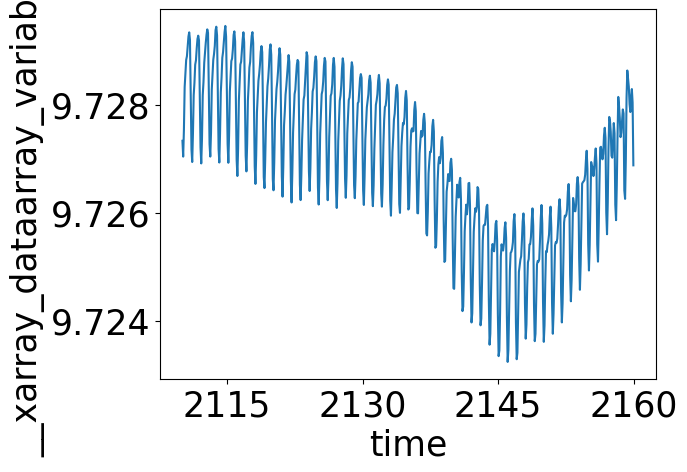

In [222]:
salt_1500_2000.__xarray_dataarray_variable__.plot()

In [202]:
salt_1500_2000[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_N_ASC_edge_2400_2500_masked.nc')

In [203]:
temp_1500_2000[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_N_ASC_edge_2400_2500_masked.nc')

In [46]:
%%time
temp_0_500, temp_500_1000, temp_1000_1500, temp_1500_2000 = var_field_isobath('temp')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

load
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

0,500
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(250, 1200), meta=np.ndarray>
0,500
<xarray.DataArray (time: 600, yt_ocean: 440, xt_ocean: 3600)> Size: 8GB
dask.array<truediv, shape=(600, 440, 3600), dtype=float64, chunksize=(3, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.15 -60.1 -60.05
  

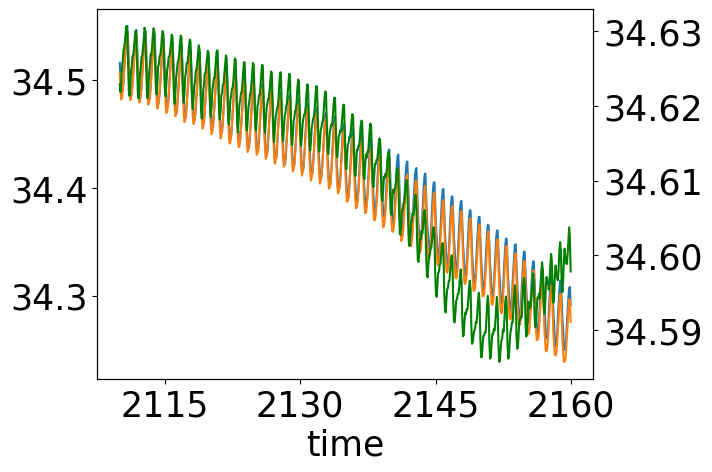

In [94]:
#xr.concat([salt_1500_2000[i].rename('salt') for i in range(6)], dim = 'time').plot()
fig, ax = plt.subplots()
salt_1000_1500[0].plot()
salt_500_1000[0].plot()
ax2 = ax.twinx()
salt_1500_2000[0].plot(ax = ax2, c = 'g')


In [47]:
temp_0_500[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_S_CC_edge_masked.nc')
temp_500_1000[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_N_CC_edge_masked.nc')
temp_1000_1500[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_S_ASC_edge_masked.nc')
#temp_1500_2000[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_N_ASC_edge_masked.nc')

In [48]:
salt_0_500[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_S_CC_edge_masked.nc')
salt_500_1000[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_N_CC_edge_masked.nc')
salt_1000_1500[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_S_ASC_edge_masked.nc')
#salt_1500_2000[0].to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/salt_N_ASC_edge_masked.nc')

In [ ]:
import gc 
c.run(gc.collect)

In [53]:
## calculate thermal wind velocity

## plotting master

In [26]:
diff_temp_ASC_t = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_600_ASC_t_scaled.nc')
diff_temp_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_temp_600_ACoC_t_scaled.nc')
diff_salt_ASC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_600_ASC_t_scaled.nc')
diff_salt_ACoC_t= xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/diff_salt_600_ACoC_t_scaled.nc')

In [27]:
# constants
H_ASC = 1500 #[m]
H_ACoC = 700 # [m]
rho = 135 #[kg/m3]'
alpha = 1e-4 #[K^{-1}]#
beta = 7.5e-4 # [kg/g]
g = 9.81 # [m/s]
f = -1.3e-4 #[s^{-1}]


In [28]:
T_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.temp + beta * -diff_salt_ASC_t.salt)
T_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.temp + beta * -diff_salt_ACoC_t.salt)
## salt diff calculates a S - N, minus signs to reverse
# in [Sv]

In [29]:
 temp_comp_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.temp)
salt_comp_ASC = g*H_ASC**2/f *(beta * -diff_salt_ASC_t.salt)
 temp_comp_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.temp)
salt_comp_ACoC = g*H_ACoC**2/f *(beta * -diff_salt_ACoC_t.salt)

Text(0.5, 1.0, 'Estimated circumpolar depth-av \n transport through thermal wind balance')

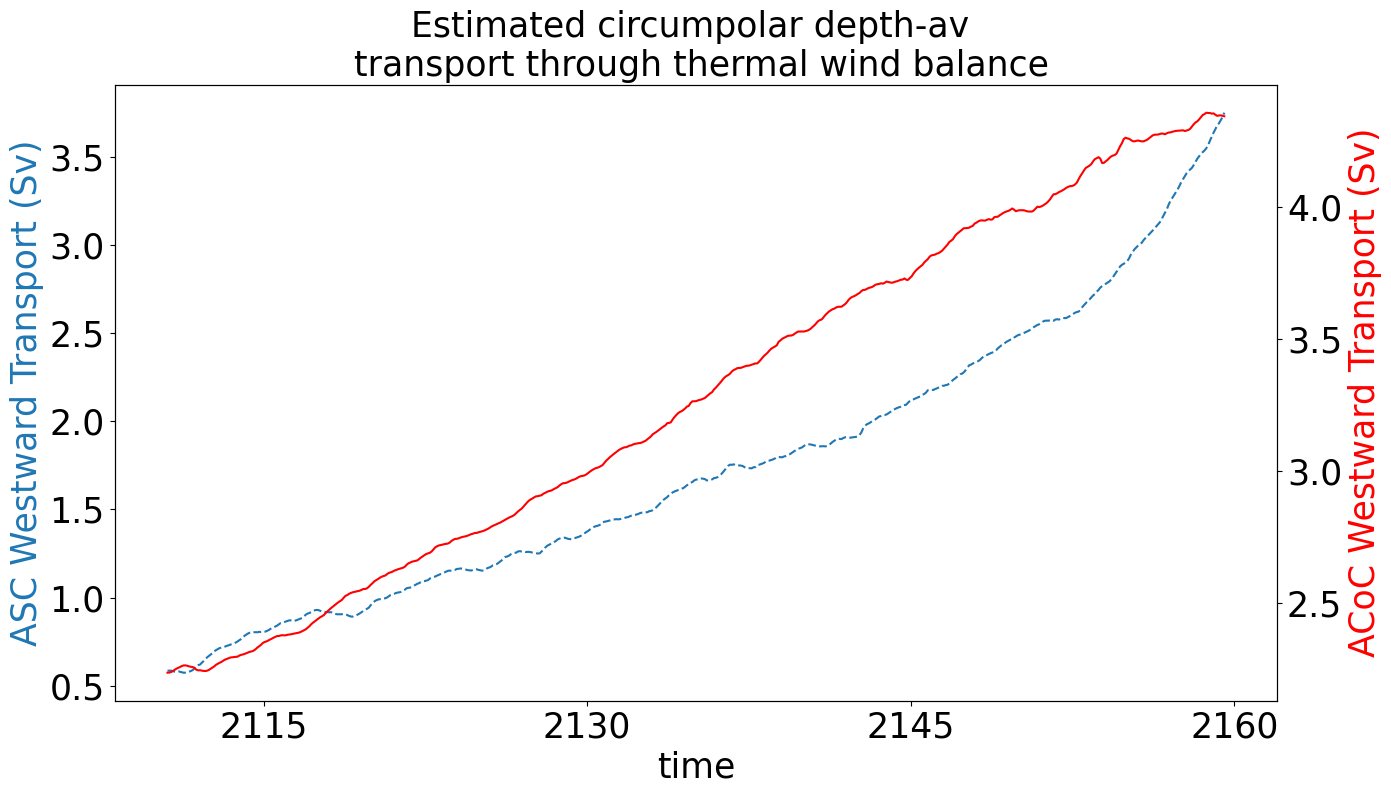

In [61]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC depth-av')

#ax.set_ylim([15,18])
ax.set_ylabel('ASC Westward Transport (Sv)', color ='C0')

ax2 = ax.twinx()
(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot(label = 'ACoC depth-av', color = 'r')

#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])
#ax2.set_ylim([0,3])
ax2.set_ylabel('ACoC Westward Transport (Sv)', color ='r')
ax2.set_title('Estimated circumpolar depth-av \n transport through thermal wind balance')

Text(0, 0.5, 'ASC transport (Sv)')

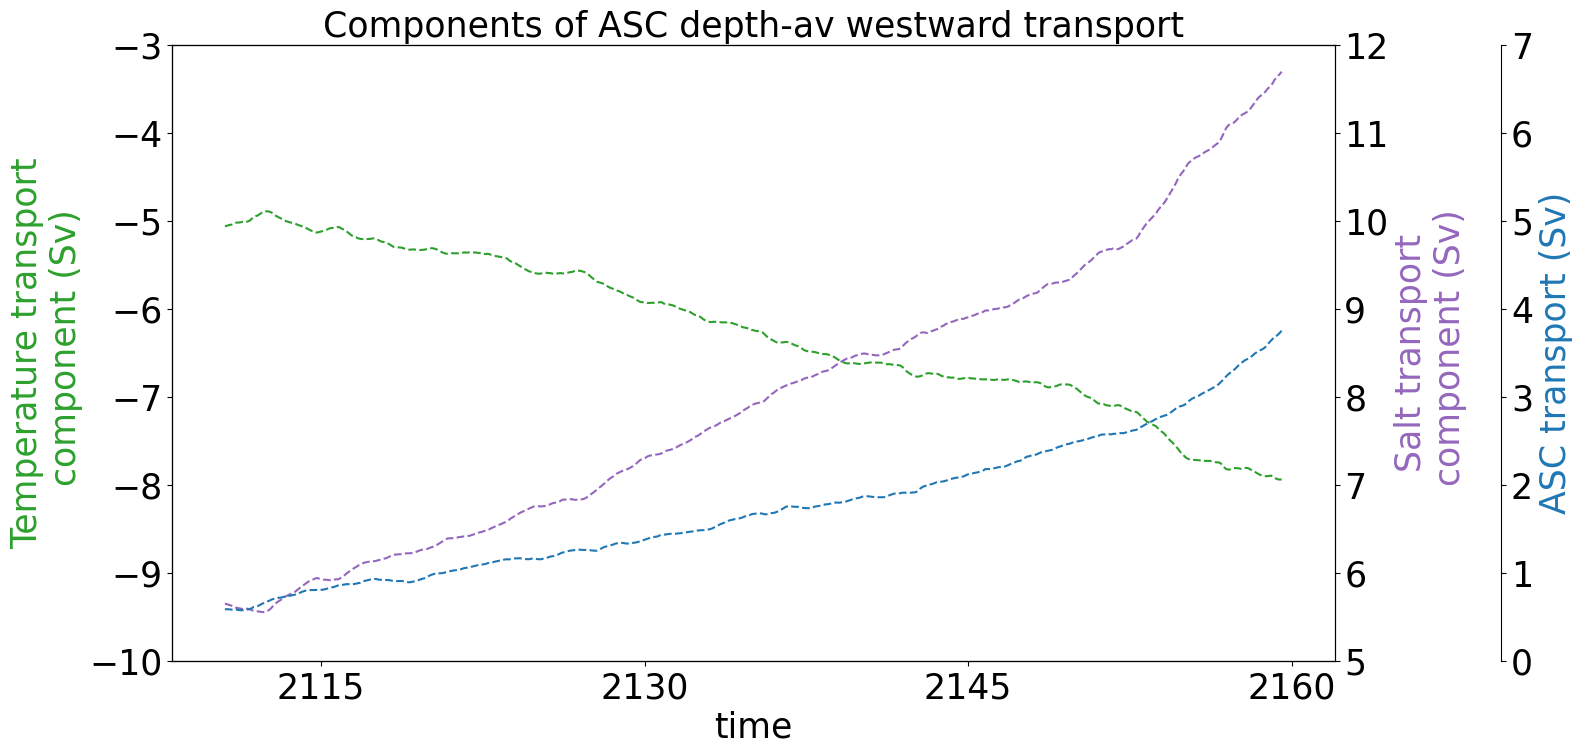

In [73]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([-10,-3])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([5,12])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax.set_title('')
ax2.set_title('Components of ASC depth-av westward transport')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 120))


(-T_ASC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ASC depth-av', ax = ax3)
ax3.set_ylim([0,7])
ax3.set_ylabel('ASC transport (Sv)', color= 'C0')

#(-salt_comp_ASC/1e6 + -temp_comp_ASC/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)

#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

(2.0, 5.0)

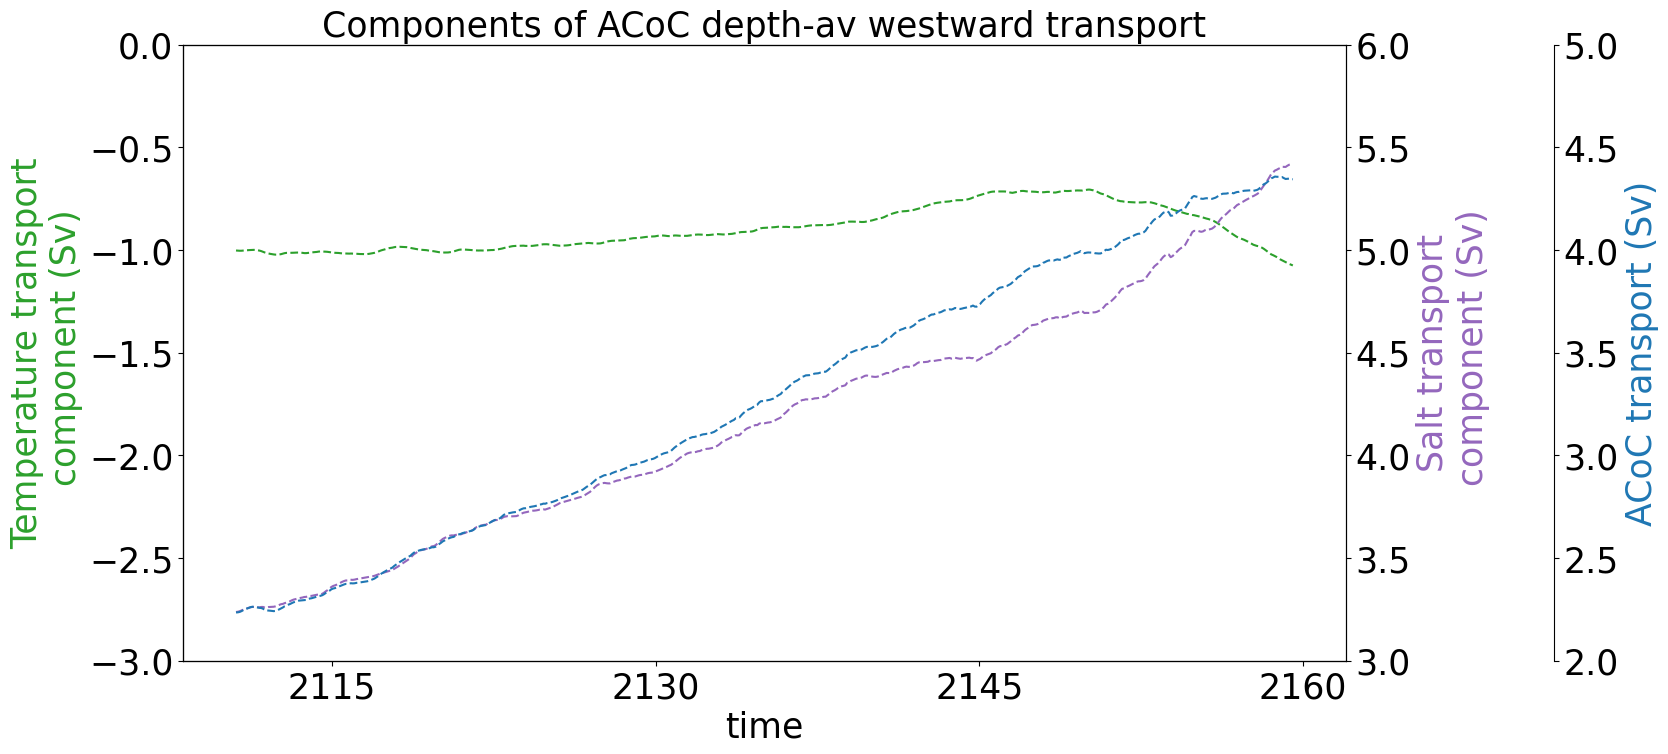

In [74]:
fig, ax = plt.subplots(figsize = (15,8))

(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C2')
ax.set_ylim([-3,0])
ax.set_ylabel('Temperature transport\n component (Sv)', color= 'C2')
ax2 = ax.twinx()

(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',color = 'C4')
ax2.set_ylim([3,6])
ax2.set_ylabel('Salt transport\n component (Sv)', color= 'C4')

ax.set_title('')
ax2.set_title('Components of ACoC depth-av westward transport')


ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 150))

(-T_ACoC/1e6).rolling(time = 12, center = True).mean().plot( ls = 'dashed',label = 'ACoC depth-av', ax = ax3)
#(-salt_comp_ACoC/1e6 + -temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean().plot(marker = 'x',color = 'k', ax = ax3)
ax3.set_ylabel('ACoC transport (Sv)', color= 'C0')

ax3.set_ylim([2,5])
#(-temp_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C2')
#(-salt_comp_ACoC_surf/1e6).rolling(time = 12, center = True).mean().plot(color = 'C4')

## temp differences isobath

In [49]:
FileList = ['temp_S_CC_edge_masked.nc','temp_N_CC_edge_masked.nc',  'temp_S_ASC_edge_masked.nc','temp_N_ASC_edge_2400_2500_masked.nc','temp_N_ASC_edge.nc'] #_1800
temp_dir = ['/g/data/v45/qo9901/MW-perturb-ASC-data/' + (FileList[i]) for i in range(len(FileList))]
[temp_0_500,temp_500_1000,  temp_1000_1500,  temp_1500_2000,temp_1800] = \
    [xr.open_mfdataset(temp_dir[i]) for i in range(len(FileList))]
temp_0_500

<xarray.Dataset> Size: 10kB
Dimensions:                        (time: 600)
Coordinates:
  * time                           (time) object 5kB 2110-01-16 12:00:00 ... ...
Data variables:
    __xarray_dataarray_variable__  (time) float64 5kB dask.array<chunksize=(600,), meta=np.ndarray>

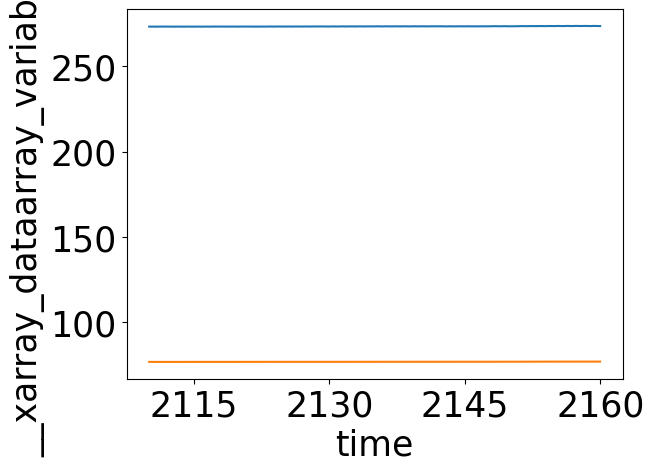

In [206]:
xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_N_ASC_edge_2400_2500.nc').__xarray_dataarray_variable__.plot()
xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/temp_N_ASC_edge_2400_2500_masked.nc').__xarray_dataarray_variable__.plot()

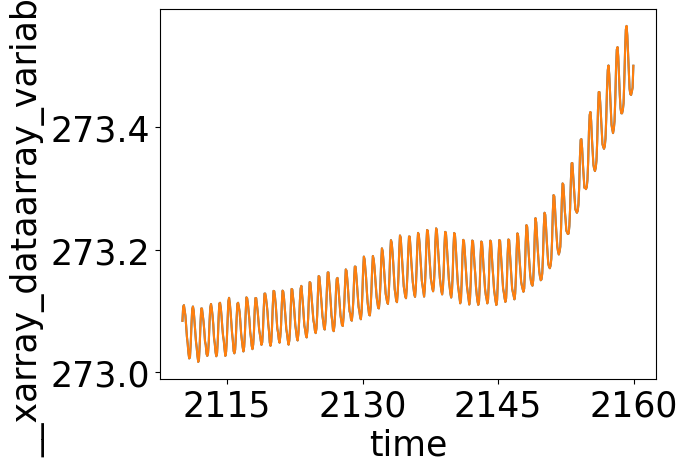

In [181]:
(temp_1500_2000 ).__xarray_dataarray_variable__.plot() # 1900-2000m
(temp_1800 ).__xarray_dataarray_variable__.plot() #1800-2000m

In [50]:
FileList = ['salt_S_CC_edge_masked.nc','salt_N_CC_edge_masked.nc',  'salt_S_ASC_edge_masked.nc','salt_N_ASC_edge_2400_2500_masked.nc'] #_1800
salt_dir = ['/g/data/v45/qo9901/MW-perturb-ASC-data/' + (FileList[i]) for i in range(len(FileList))]
[salt_0_500,salt_500_1000,  salt_1000_1500,  salt_1500_2000 ] = \
    [xr.open_mfdataset(salt_dir[i]) for i in range(len(FileList))]
salt_0_500

<xarray.Dataset> Size: 10kB
Dimensions:                        (time: 600)
Coordinates:
  * time                           (time) object 5kB 2110-01-16 12:00:00 ... ...
Data variables:
    __xarray_dataarray_variable__  (time) float64 5kB dask.array<chunksize=(600,), meta=np.ndarray>

In [51]:
mask_500_1000 = xr.where((ht < 600) & (ht >500 ), True, False) 
mask_0_500 = xr.where( ht < 200 , True, False) 
mask_1500_2000 = xr.where((ht < 2500) & (ht > 2400), True, False)  
mask_1000_1500 = xr.where((ht < 700) & (ht > 600), True, False) 


In [52]:
(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values

array(5.076218e+10, dtype=float32)

In [63]:

temp_0_500_scaled = temp_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t*cluster_mask_access).where(mask_0_500 == True).sum().values
temp_500_1000_scaled = temp_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t*cluster_mask_access).where(mask_500_1000 == True).sum().values
temp_1000_1500_scaled = temp_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t*cluster_mask_access).where(mask_1000_1500 == True).sum().values
temp_1500_2000_scaled = temp_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values

salt_0_500_scaled = salt_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t*cluster_mask_access).where(mask_0_500 == True).sum().values
salt_500_1000_scaled = salt_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t*cluster_mask_access).where(mask_500_1000 == True).sum().values
salt_1000_1500_scaled = salt_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t*cluster_mask_access).where(mask_1000_1500 == True).sum().values
salt_1500_2000_scaled = salt_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values
'''
temp_0_500_scaled = temp_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t).where(mask_0_500 == True).sum().values
temp_500_1000_scaled = temp_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t).where(mask_500_1000 == True).sum().values
temp_1000_1500_scaled = temp_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t).where(mask_1000_1500 == True).sum().values
temp_1500_2000_scaled = temp_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values

salt_0_500_scaled = salt_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t).where(mask_0_500 == True).sum().values
salt_500_1000_scaled = salt_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t).where(mask_500_1000 == True).sum().values
salt_1000_1500_scaled = salt_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t).where(mask_1000_1500 == True).sum().values
salt_1500_2000_scaled = salt_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values
'''

'\ntemp_0_500_scaled = temp_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t).where(mask_0_500 == True).sum().values\ntemp_500_1000_scaled = temp_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t).where(mask_500_1000 == True).sum().values\ntemp_1000_1500_scaled = temp_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t).where(mask_1000_1500 == True).sum().values\ntemp_1500_2000_scaled = temp_1500_2000*area_t.where(mask_1500_2000 == True).sum().values/(area_t*cluster_mask_access).where(mask_1500_2000 == True).sum().values\n\nsalt_0_500_scaled = salt_0_500*area_t.where(mask_0_500 == True).sum().values/(area_t).where(mask_0_500 == True).sum().values\nsalt_500_1000_scaled = salt_500_1000*area_t.where(mask_500_1000 == True).sum().values/(area_t).where(mask_500_1000 == True).sum().values\nsalt_1000_1500_scaled = salt_1000_1500*area_t.where(mask_1000_1500 == True).sum().values/(area_t).where(mask_1000_1500 == True).sum().values\nsalt_1500_2000_scaled

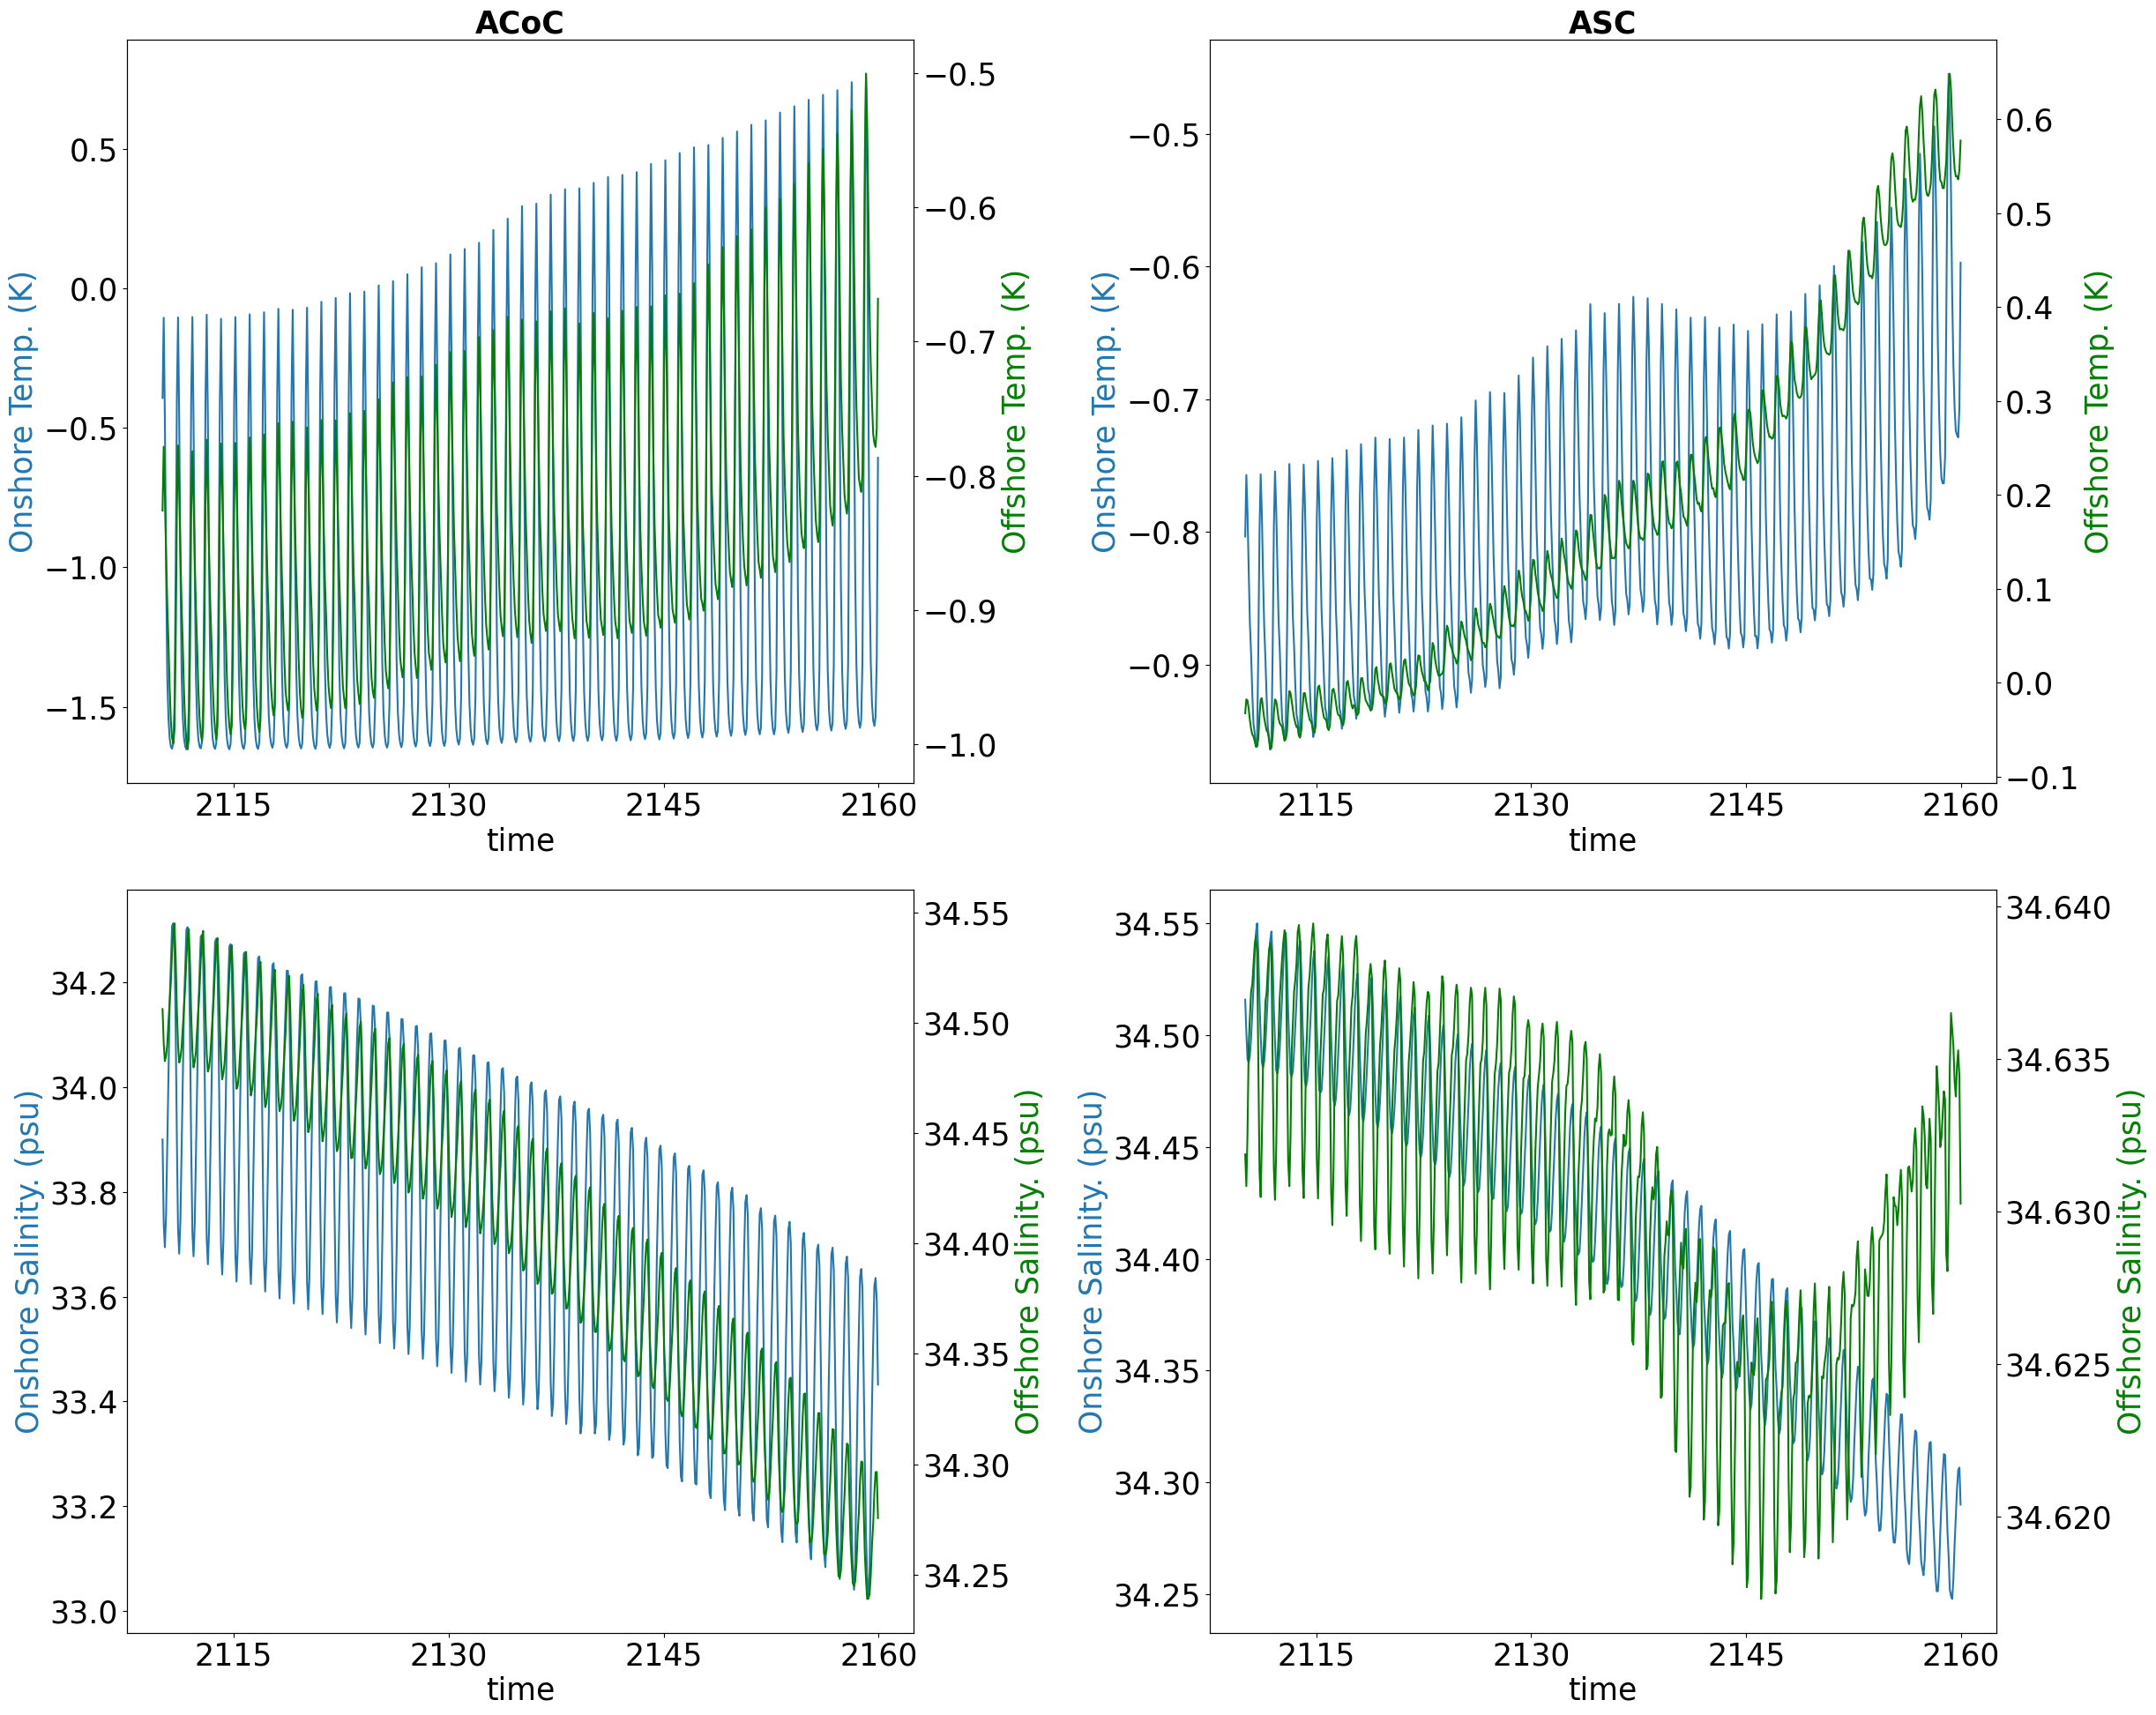

In [64]:
fig,ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25,20))
(temp_0_500_scaled.__xarray_dataarray_variable__ - 273).plot(ax = ax[0,0])
ax2 = ax[0,0].twinx()
(temp_500_1000_scaled.__xarray_dataarray_variable__- 273).plot(c = 'g',ax = ax2)
ax[0,0].set_title('ACoC', weight = 'bold')

#ax[0,0].set_ylim([-1.3,-0.3])
ax[0,0].set_ylabel('Onshore Temp. (K)',c = 'C0')
#ax2.set_ylim([-1.3,-0.3])
ax2.set_ylabel('Offshore Temp. (K)',c = 'g')

(temp_1000_1500_scaled.__xarray_dataarray_variable__- 273).plot(ax = ax[0,1])
ax2 = ax[0,1].twinx()
(temp_1500_2000_scaled.__xarray_dataarray_variable__- 273).plot(c = 'g',ax = ax2)
ax[0,1].set_title('ASC', weight = 'bold')

#ax[0,1].set_ylim([-0.7,0.5])
ax[0,1].set_ylabel('Onshore Temp. (K)',c = 'C0')
#ax2.set_ylim([-0.7,0.5])
ax2.set_ylabel('Offshore Temp. (K)',c = 'g')
                  
salt_0_500_scaled.__xarray_dataarray_variable__.plot(ax = ax[1,0])
ax2 = ax[1,0].twinx()
salt_500_1000_scaled.__xarray_dataarray_variable__.plot(c = 'g',ax = ax2)
#ax[1,0].set_ylim([34,34.6])
ax[1,0].set_ylabel('Onshore Salinity. (psu)',c = 'C0')
#ax2.set_ylim([34.,34.6])
ax2.set_ylabel('Offshore Salinity. (psu)',c = 'g')

salt_1000_1500_scaled.__xarray_dataarray_variable__.plot(ax = ax[1,1])
ax2 = ax[1,1].twinx()
salt_1500_2000_scaled.__xarray_dataarray_variable__.plot(c = 'g',ax = ax2)

#ax[1,1].set_ylim([34.44,34.61])
ax[1,1].set_ylabel('Onshore Salinity. (psu)',c = 'C0')
#ax2.set_ylim([34.44,34.61])
ax2.set_ylabel('Offshore Salinity. (psu)',c = 'g')

plt.tight_layout()

In [65]:
diff_temp_ASC_t = temp_1000_1500_scaled - temp_1500_2000_scaled
diff_temp_ACoC_t= temp_0_500_scaled - temp_500_1000_scaled
diff_salt_ASC_t= salt_1000_1500_scaled - salt_1500_2000_scaled
diff_salt_ACoC_t= salt_0_500_scaled - salt_500_1000_scaled

In [78]:
# constants
H_ASC = 1000 #[m]
H_ACoC = 200 # [m]
rho = 1035 #[kg/m3]'
alpha = 1e-4 #[K^{-1}]#
beta = 7.5e-4 # [kg/g]
g = 9.81 # [m/s]
f = -1.3e-4 #[s^{-1}]


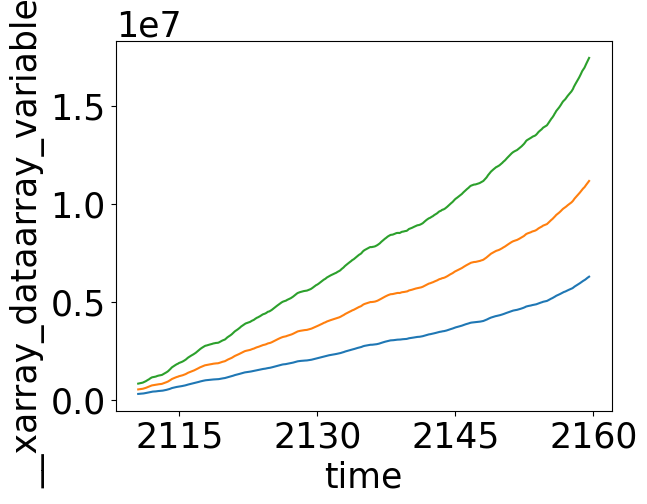

In [67]:
T_ASC_750 = g*750**2/f *(-alpha  * -diff_temp_ASC_t.__xarray_dataarray_variable__ + beta * -diff_salt_ASC_t.__xarray_dataarray_variable__)
T_ASC_1000 = g*1000**2/f *(-alpha  * -diff_temp_ASC_t.__xarray_dataarray_variable__ + beta * -diff_salt_ASC_t.__xarray_dataarray_variable__)
T_ASC_1500 = g*1250**2/f *(-alpha  * -diff_temp_ASC_t.__xarray_dataarray_variable__ + beta * -diff_salt_ASC_t.__xarray_dataarray_variable__)
(-T_ASC_750).rolling(time = 12, center = True).mean().plot()
(-T_ASC_1000).rolling(time = 12, center = True).mean().plot()
(-T_ASC_1500).rolling(time = 12, center = True).mean().plot()

In [79]:
T_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.__xarray_dataarray_variable__ + beta * -diff_salt_ASC_t.__xarray_dataarray_variable__)
T_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.__xarray_dataarray_variable__ + beta * -diff_salt_ACoC_t.__xarray_dataarray_variable__)
## salt diff calculates a S - N, minus signs to reverse
# in [Sv]

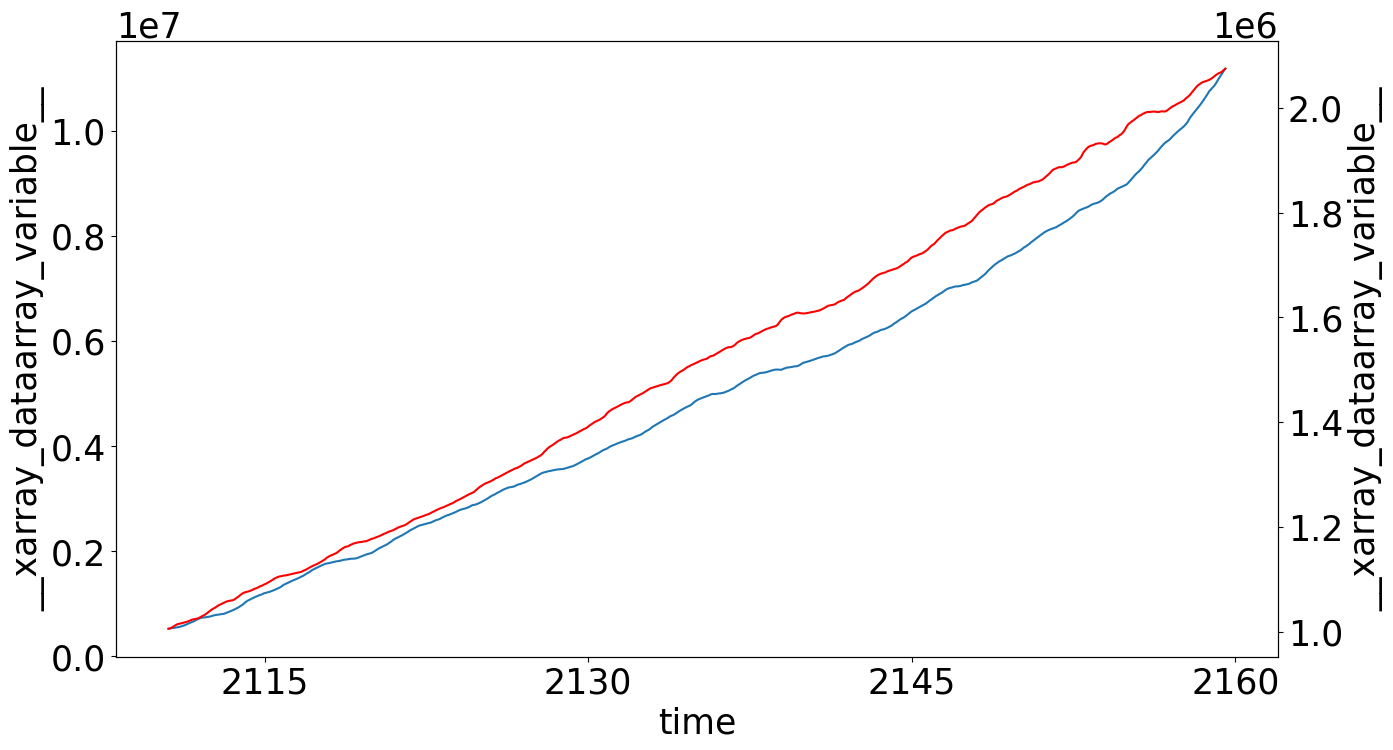

In [80]:
fig, ax = plt.subplots(figsize = (15,8))
(-T_ASC).rolling(time = 12, center = True).mean().plot()
#ax.set_ylim([5.92e8,5.98e8])
ax2 = ax.twinx()
(-T_ACoC).rolling(time = 12, center = True).mean().plot(color = 'r')
#ax2.set_ylim([2.56e6 ,2.56e6 + 0.06e8])


In [81]:
 temp_comp_ASC = g*H_ASC**2/f *(-alpha  * -diff_temp_ASC_t.__xarray_dataarray_variable__)
salt_comp_ASC = g*H_ASC**2/f *(beta * -diff_salt_ASC_t.__xarray_dataarray_variable__)
 temp_comp_ACoC = g*H_ACoC**2/f *(-alpha  * -diff_temp_ACoC_t.__xarray_dataarray_variable__)
salt_comp_ACoC = g*H_ACoC**2/f *(beta * -diff_salt_ACoC_t.__xarray_dataarray_variable__)

In [82]:
import cftime

In [ ]:
## master plot
lw = 3
#np.set_printoptions(precision=3)
from matplotlib.ticker import FormatStrFormatter

fig,ax = fig, ax = plt.subplot_mosaic("ab;cd;ef", figsize = (25,20))



onshore_offshore_clr = ['brown', 'darkblue']
(temp_0_500_scaled.__xarray_dataarray_variable__ - 273).rolling(time = 12, center = True).mean().plot(label = 'Onshore',\
                                    color = onshore_offshore_clr[0], ax = ax['a'], lw = lw)
(temp_500_1000_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean().plot( label = 'Offshore', \
                                      color = onshore_offshore_clr[1], ax = ax['a'], lw = lw)
ax['a'].fill_between(salt_0_500_scaled.time.values, \
                     (temp_0_500_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_500_1000_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean().values, \
                     alpha = 0.15, color = 'C2')
ax['a'].set_title('ACoC', weight = 'bold')
#ax['a'].set_ylim([-1.3,-0.3])
ax['a'].set_ylabel(r'Temp. ($\degree$C)')
ax['a'].legend(loc = 'lower right')

(temp_1000_1500_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[0], ax = ax['b'], lw = lw)
(temp_1500_2000_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1],ax = ax['b'], lw = lw)

ax['b'].fill_between(temp_1000_1500_scaled.time.values, \
                     (temp_1000_1500_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean().values,\
                     (temp_1500_2000_scaled.__xarray_dataarray_variable__- 273).rolling(time = 12, center = True).mean().values,\
                     alpha = 0.15, color = 'C2')

ax['b'].set_title('ASC', weight = 'bold')

#ax['b'].set_ylim([-0.7,0.5])
ax['b'].set_ylabel('')
  
salt_0_500_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[0],ax = ax['c'], lw = lw)
salt_500_1000_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot( color = onshore_offshore_clr[1],ax = ax['c'], lw = lw)
ax['c'].fill_between(salt_0_500_scaled.time.values, salt_0_500_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().values,\
                     salt_500_1000_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['c'].set_ylim([33.2,34.7])
ax['c'].set_ylabel('Salinity. (psu)')

salt_1000_1500_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[0],ax = ax['d'], lw = lw)
salt_1500_2000_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean()\
    .plot( color = onshore_offshore_clr[1], ax = ax['d'], lw = lw)
ax['d'].fill_between(salt_1500_2000_scaled.time.values, \
                     salt_1500_2000_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().values,\
                     salt_1000_1500_scaled.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().values, alpha = 0.15, color = 'C4')
ax['d'].set_ylim([34.25,34.7])
ax['d'].set_ylabel('')


(-T_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot(ax = ax['e'], label = 'ACoC depth-av', color = 'C0', lw = 5)
ax2 = ax['e'].twinx()
ax['e'].set_ylim([0.8,2.2])

ax2.spines['right']
(-temp_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax2, lw = lw, label = 'Temp.component')
ax2.set_ylim([-0.6,0.8])
ax2.set_yticklabels(labels = ax2.get_yticks(), color = 'C2')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylabel('')

ax3 = ax['e'].twinx()
ax3.spines['right'].set_position(('outward', 70))
ax3.set_ylim([0.8,2.2])
(-salt_comp_ACoC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax3, lw = lw, label = 'Salinity component')
ax3.set_yticklabels(labels = ax3.get_yticks(), color = 'C4')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax3.set_ylabel('', color= 'C4')

ax['e'].set_yticklabels(labels = ax['e'].get_yticks(), color = onshore_offshore_clr[1], fontweight = 'bold')
ax['e'].set_ylabel('Westward Transport (Sv)', color = onshore_offshore_clr[1], fontweight = 'bold')

### Do everything for plot4 as before
handles4,labels4 = ax2.get_legend_handles_labels()
### Do everything for plot4a
handles4a,labels4a = ax3.get_legend_handles_labels()
### Combine the legend handles and labels to make a new legend object
handles = handles4 + handles4a
labels = labels4 + labels4a


(-T_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( label = 'ASC depth-av', ax = ax['f'], lw = 5, ylim = (0,16))
ax['f'].set_yticks(range(0,16,4))
ax['f'].set_yticklabels(labels =  ax['f'].get_yticks(), color = onshore_offshore_clr[1], fontweight = 'bold')
ax['f'].set_ylabel('')

ax4 = ax['f'].twinx()
(-temp_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C2', ax = ax4, lw = lw)
ax4.set_yticks(range(-10,6,4))
ax4.set_yticklabels(labels = ax4.get_yticks(), color = 'C2')
ax4.set_ylabel('')

ax5 = ax['f'].twinx()
ax5.spines['right'].set_position(('outward', 70))
ax5.set_yticks(range(6,22,4))
(-salt_comp_ASC/1e6).rolling(time = 12, center = True).mean()\
    .plot( color = 'C4', ax = ax5, lw = lw)
ax5.set_yticklabels(labels = ax5.get_yticks(), color = 'C4')
ax5.set_ylabel('')

#ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


for letter in list(map(chr, range(ord('a'), ord('f')+1))):
        ax[letter].set_xticks(salt_1000_1500_scaled.time[::120].values)
        ax[letter].set_xticklabels(np.arange(2000,2050,10))
        ax[letter].set_xlabel('Year')
        ax[letter].text(0.01,0.93,'(' + letter + ')', \
                        transform=ax[letter].transAxes, fontweight = 'bold')
ax['e'].legend(handles, labels, loc = 'lower center')

plt.tight_layout()